## Obtención de columnas con persistencia temporal y agrupación de Promedio, máximo y mínimo por hora.

#### Diseño del modelo

Una vez que se obtienen los datos limpios, estos pueden ser utilizados para una serie de pruebas, donde se decidirá la granularidad temporal y la representatividad geográfica con la que se va a efectuar el pronóstico. Este proceso es iterativo: se aplica un procesamiento a los datos, se entrenan los modelos y se analiza su desempeño. A continuación se muestran las principales variantes de los modelos generados así como sus descripción:


<img src="./fotos_markdown/diseno_modelo.png" style="height:300px">

* __Pronóstico por estación__: Se generó un modelo para todas las estaciónes de monitoreo. Debido a que la mayoría de las estaciones solo miden un subconjunto de todas las variables y no todas a la vez, los modelos generados sólo resultaron viables para las estaciones que miden todas las variables. Para la mayoría de las estaciones donde la cantidad de variables es baja,  el modelo subestima los valores de pronóstico.


* __Pronóstico para toda la Ciudad__: Para poder solventar que no todas las estaciones miden las mismas variables, se obtuvo el promedio, el mínimo y el máximo de los valores medidos en todas las estaciones por cada hora, al tomar estos valores, se pierde el atributo de la estación. El pronóstico mejoró, sin embargo el desempeño no era el esperado debido a los numerosos falsos positivos: la información-base de los modelos no era suficiente para describir el fenómeno.


* __Pronóstico por día__: Junto al proceso anterior, se procedió a volver a sacar el promedio, el mínimo y el máximo pero en esta ocasión por día y no por hora. Se obtuvo un modelo de pronóstico del valor máximo de cada día. El resultado no fue el esperado, el resultado mejoró considerablemente a comparación de los dos procesos anteriores sin embargo, el modelo seguía pronosticando demasiados falsos negativos: la contingencia no se pronosticaba correctamente debido a que al promediar por día, se pierde la información horaria y disminuye considerablemente el número de registros.


* __Pronóstico con persistencia temporal__: Usando los datos del pronóstico por hora para toda la ciudad, se utilizó la persistencia observada en el fenómeno entre horas pasadas y presentes, para generar nuevas columnas con los atributos de horas pasadas más correlacionadas con el presente. Se volvieron a entrenar los modelos con estas variables nuevas, obteniendo resultados satisfactorios.


__Pasos y descripción general del notebook__


El modelo elegido es el __horario con persistencia temporal__, habiendo obtenido la más baja tasa de falsos negativos y falsos positivos. Más adelante se expone su análisis con métricas de desempeño. A continuación se muestra el proceso para obtener los datos de entrenamiento del modelo:

<img src="./fotos_markdown/diagrama_2.png" style="height:350px">



1. __Contaminantes de horas anteriores más correlacionadas:__ se obtiene la correlación, de las variables meteorológicas y de contaminación, entre sus valores de una hora atrás con los de 72 horas atrás consigo mismas, de 1 hasta 72 horas atrás. El resultado es una una tabla de correlación temporal desplazada temporalmente la cual nos servirá para poder filtrar las variables más correlacionadas, es decir, las que más influyen en los niveles de contaminación.


2. __Aplicar Desplazamiento temporal:__ a partir de tablas de correlación temporal desplazada, se hace una columna para cada variable correlacionada: cuando existe una correlación mayor a 0.44 de cualquier atributo con los contaminantes mencionados, se hace una nueva columna con estos valores.



3. __Max, Mean, Min:__ se obtiene el máximo, el promedio y el mínimo de cada variable por hora, el resultado es una tabla con una sola fila por cada hora, en esta tabla se pierde el atributo de estación y así la información geográfica de donde se tomó la medición.


4. __Generar las columna a pronosticar:__ Se genera la columna con el valor del conntaminante a pronosticar a 24 horas y se obtiene la correlación de los valores promedio máximo y mínimo con éste. Por último se Filtran los valores más importantes.


5. __Generar las columnas de pronóstico de RH, WSP TMP:__ Se generan columnas con el pronóstico meteorológico  de estos atributos.


6. __Generar las columnas del contaminante a pronosticar de 1 hasta 23 horas:__ Se generan las columnas con el valor del contaminante a prononsticar desde 1 hasta 24 horas.



- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com

Este notebook presenta el proceso donde se ha obtenido los mejores desempeños de los modelos de los contaminantes. Después de un proceso iterativo y de un análisis del desempeño de los modelos, se obtuvieron las siguientes conclusiones:

- Utilizar la propiedad de persistencia temporal, mejora significativamente los modelos.


- Obtener el promedio, el máximo y el mínimo por hora en lugar de trabajar con la medición de cada estación, genera una consolidación de las mediciones y disminuye el efecto negativo de los atributos faltantes en las mediciones a raíz de las capacidades de las estación de monitoreo.


- Añadir el pronóstico meteorológico a 24 horas, añade fiabilidad a los modelos disminuyendo el error asociado del pronóstico. Este pronóstico se obtendrá posteriormente de una fuente externa.


In [1]:
from sklearn.datasets import make_regression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

import seaborn as sn
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sn


In [2]:
def specifity(y_true, y_pred):
    tn, fp, fn, tp = confussion_matrix_function(y_true.tolist(), y_pred.tolist()).ravel()
    specifity_score = tp / (fn+fp)
    return specifity_score

 # score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
specifity_scorer = make_scorer(specifity, greater_is_better=True)

In [3]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

In [4]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=154, color='k', linestyle='--')
    plt.axvline(x=154, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

In [5]:
Contaminantes = ["O3","PM10mean","PM25mean"]

In [6]:
contaminante = Contaminantes[2]
contaminante

'PM25mean'

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
pd.options.mode.chained_assignment = None 
import seaborn as sns

In [8]:
data_hour_merge_24 = pd.read_csv('./datos/datos_entrenamiento.csv')

In [9]:
data_hour_merge_24 = data_hour_merge_24.dropna(subset=[contaminante]).reset_index(drop=True)#PM25

In [10]:
data_hour_merge_24.head(5)

,RH,TMP,WSP,id_station,fecha,CO,NO,NO2,NOX,O3,PM10,PM2.5,SO2,hora,dia,mes,PM10mean,PM25mean
0,NaN,NaN,NaN,CAM,2015-01-02 00:00:00,1.7,NaN,NaN,NaN,1.0,46.0,32.0,4.0,0,2.0,1.0,97.625000,83.916667
1,NaN,NaN,0.5,MGH,2015-01-02 00:00:00,1.8,146.0,32.0,178.0,1.0,36.0,25.0,3.0,0,2.0,1.0,109.916667,96.583333
2,51.0,10.5,1.2,PED,2015-01-02 00:00:00,0.6,10.0,32.0,42.0,NaN,14.0,5.0,2.0,0,2.0,1.0,94.750000,73.208333
3,NaN,NaN,NaN,CAM,2015-01-02 01:00:00,1.6,NaN,NaN,NaN,2.0,42.0,32.0,5.0,1,2.0,1.0,95.416667,81.916667
4,NaN,NaN,0.6,MGH,2015-01-02 01:00:00,1.6,142.0,30.0,172.0,1.0,31.0,21.0,3.0,1,2.0,1.0,104.333333,91.375000


In [11]:
example=data_hour_merge_24.dropna(subset=["PM10mean"],axis=0)

## 1. 
### Usando el archivo de correlación con retraso temporal, se crean nuevas columnas con el atributo y las horas atrás.


La corraloción con retraso temporal se refiere a la influencia que tienen las condiciones atmosféricas de un hora dada sobre las condiciones futuras, por ejemplo, si el nivel de contaminación de actual es alto ¿este valor influirá en la contaminación del día siguiente o la contaminación de cada día no se ve influida por valores pasados? La respuesta es la primera opción, valores pasados de las condiciones atmosféricas influyen fuertemente en la contaminación _actual_.

Esta propiedad es clave para la generación de un modelo estadístico, la existencia de patrones y de factores que aparentemente influyen en la contaminación nos permiten tener un conjunto de datos que determinen la contaminación.


La generación de la correlación se encuentra en: __/home/paw/DanielBustillos/contaminación/correlaciones_pau/correlaciones_función_paulina.ipynb__

In [12]:
target = str(contaminante + "_y")
target

'PM25mean_y'

In [13]:
corr_path = str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/correlaciones_pau/"+
    contaminante +"_max_corr.csv")

In [14]:
O3_corr = pd.read_csv(corr_path) # leemo el archivo de correlación
O3_corr = O3_corr.iloc[:,:]
O3_corr.head()

,contaminante,valor,horas
0,RH,-0.135575,0.0
1,TMP,0.002037,0.0
2,WSP,-0.104811,0.0
3,CO,0.326505,0.0
4,NO,0.180772,0.0


- La columna "contaminante" se tiene el atributo sobre el que se realizó la correlación.
- La columna "valor" indica el valor de la correlación.
- La columna "horas" indica las horas de retraso.

Vamos a aplicar un filtro, nos quedaremos con las variables con una correlación entre -0.44 y 0.44. Este valor se eligió de forma que la cantidad de atributos final sea menor a 110:

In [15]:
if contaminante == "O3":
    threshold = 0.35
else: threshold = 0.45

In [16]:
O3_corr_filtro = O3_corr[(O3_corr.valor > threshold ) | (O3_corr.valor < - threshold) ].reset_index(drop=True)
O3_corr_filtro.shape

(167, 3)

Una vez que tenemos los contaminantes y el número de horas de retraso, definimos una función que nos genere una nueva columna con el contaminante recorrido temporalmente las horas indicadas en **O3_corr_filtro**:

In [17]:
def shit_corr(df):
    for i in range(len(O3_corr_filtro)):
        name_column = str( O3_corr_filtro.loc[i,"contaminante"] + "_" + str(
            O3_corr_filtro.loc[i,"horas"])) # se define el nombre de la columna a crear con el formato:
                                            # contaminante _ horas de retraso
        df[name_column] = df[O3_corr_filtro.loc[i,"contaminante"]].shift(
            int(float(str(O3_corr_filtro.loc[i,"horas"])))) # se toma el nombre del contaminante y se 
                                                            # desplaza temporalmente las horas indicadas
    return df.dropna()

Debido a que por cada hora se tienen tantos registros como el número de estaciones de monitoreo, existen fechas duplicadas en el df:

Al tener fechas duplicadas, puede ocurrrir errores al aplicar el desplazamiento, por este motivo vamos a generar **un dataframe por cada estación**, aplicaremos la función y por último uniremos los dataframes:

In [18]:
estaciones = data_hour_merge_24.id_station.unique().tolist() # recolectamos los nombres de las estaciones
data_est = {}
for elem in estaciones:
    data_est[elem] = data_hour_merge_24[data_hour_merge_24.id_station == elem] #hacemos un df por estación

Aplicamos la función para cada dataframe:

In [19]:
data_shift = {}
for elem in data_est:
    data_shift[elem] = shit_corr(data_est[elem])

Unimos los dataframes:

In [20]:
df_append = pd.DataFrame(columns = data_est["MER"].columns.tolist())
for key in data_est:
    df_append = df_append.append(data_est[key], ignore_index=True,sort=True)

In [21]:
df_append.tail(5)

,CO,NO,NO2,NO2_0.0,NO2_1.0,NO2_10.0,NO2_11.0,NO2_12.0,NO2_13.0,NO2_14.0,...,PM25mean_9.0,RH,SO2,TMP,WSP,dia,fecha,hora,id_station,mes
252933,NaN,NaN,28.0,28.0,25.0,15.0,14.0,11.0,7.0,6.0,...,19.541667,80.0,NaN,14.6,0.9,31.0,2019-07-31 06:00:00,6,GAM,7.0
252934,NaN,NaN,28.0,28.0,28.0,15.0,15.0,14.0,11.0,7.0,...,19.916667,80.0,NaN,14.7,0.0,31.0,2019-07-31 07:00:00,7,GAM,7.0
252935,NaN,NaN,32.0,32.0,28.0,15.0,15.0,15.0,14.0,11.0,...,19.916667,75.0,NaN,15.9,0.8,31.0,2019-07-31 08:00:00,8,GAM,7.0
252936,NaN,NaN,40.0,40.0,32.0,17.0,15.0,15.0,15.0,14.0,...,20.083333,69.0,NaN,17.3,1.3,31.0,2019-07-31 09:00:00,9,GAM,7.0
252937,NaN,NaN,NaN,NaN,40.0,12.0,17.0,15.0,15.0,15.0,...,20.125000,66.0,NaN,17.7,1.4,31.0,2019-07-31 10:00:00,10,GAM,7.0


# 2.
### Se obtiene el promedio, máximo y mínimo por hora de todas las estaciones.

Debido a que solo algunas estaciones miden todos los atributos con los que se está trabajando, se encontró que agrupar las condiciones atmosféricas de cada atributo con el promedio, máximo y mínimo, genera una mejora considerable al desempeño final de los modelos, debido a que al hacer esta agrupación se suavizan los valores y también se homogeniza los atributos de cada estación.

Se guardan las columnas al aplicar el groupby y se elimina "fecha":

In [22]:
cols = df_append.columns.tolist() 
cols.remove("fecha")
cols.remove("id_station")
df_append[cols] = df_append[cols].astype(float)

Aplicamos los groupbys:

In [23]:
data_hour_merge_24_mean = df_append.groupby('fecha')[cols].mean()
data_hour_merge_24_mean.reset_index(inplace=True)

In [24]:
data_hour_merge_24_max = df_append.groupby('fecha')[cols].max()
data_hour_merge_24_max.reset_index(inplace=True)

In [25]:
data_hour_merge_24_min = df_append.groupby('fecha')[cols].min()
data_hour_merge_24_min.reset_index(inplace=True)

#### Cambiamos los nombres de las estaciones:
Debido a que cada groupby genera los mismos nombres, esto puede generar problemas para identificar de qué columna se trata, se cambiarán los nombres a "contaminante_max", "contaminante_min", "contaminante_mean" según corresponda.

Se obtienenn los nonbres de las columnas en forma de lista:

In [26]:
max_columns = data_hour_merge_24_max.columns.tolist()
min_columns = data_hour_merge_24_min.columns.tolist()
mean_columns = data_hour_merge_24_mean.columns.tolist()

Se cambian los nombres en las listas:

In [27]:
for i in range(len(max_columns)):
    if not max_columns[i].startswith("fecha") \
    and not max_columns[i].startswith("hora") \
    and not max_columns[i].startswith("dia") \
    and not max_columns[i].startswith("mes"):
        max_columns[i] = max_columns[i]+"_max"
        
    if not min_columns[i].startswith("fecha") \
    and not min_columns[i].startswith("hora") \
    and not min_columns[i].startswith("dia") \
    and not min_columns[i].startswith("mes"):
        min_columns[i] = min_columns[i]+"_min" 
        
    if not mean_columns[i].startswith("fecha") \
    and not mean_columns[i].startswith("hora") \
    and not mean_columns[i].startswith("dia") \
    and not mean_columns[i].startswith("mes"):
        mean_columns[i] = mean_columns[i]+"_mean"

Se renombra las columnas de los dataframes

In [28]:
data_hour_merge_24_mean.columns = mean_columns
data_hour_merge_24_min.columns = min_columns
data_hour_merge_24_max.columns = max_columns

Unimos los df's 

In [29]:
data_hour_merge = pd.merge(data_hour_merge_24_mean, data_hour_merge_24_max, on=['fecha'])
data_hour_merge = pd.merge(data_hour_merge, data_hour_merge_24_min, on=['fecha'])

In [30]:
data_hour_merge_columns = data_hour_merge.columns.tolist()

###### Eliminamos las columnas dehora dia y mes que acaben con x & y

In [31]:
for item in range(len(data_hour_merge_columns)):
    if  data_hour_merge_columns[item].endswith("_x")\
    or  data_hour_merge_columns[item].endswith("_y"):
        data_hour_merge_columns[item] = data_hour_merge_columns[item][:-2]

In [32]:
data_hour_merge.columns = data_hour_merge_columns#.tolist()

data_hour_merge = data_hour_merge.loc[:,~data_hour_merge.columns.duplicated()]

Debido a que el proceso de obtener el máximo y mínimo es lento, es conveniente guardar el archivo de manera provisional:

In [33]:
data_hour_merge.to_csv("./datos/datos_gb_" + contaminante + ".csv", sep=',', encoding='utf-8',index=False)

# Leamos el archivo:

In [34]:
data_hour_merge = pd.read_csv("./datos/datos_gb_" + contaminante + ".csv", sep=',', encoding='utf-8')

In [35]:
data_hour_merge = data_hour_merge.sort_values(['fecha',"hora"], ascending=[0,1]).reset_index(drop=True)

## 3. 
### Generar las columna a pronosticar y obtener la correlación de los valores promedio máximo y mínimo con éste. Filtrar los valores más importantes.


Ahora vamos a sacar los atributos más correlacionado con el contaminante a pronosticar a pronosticar. 

In [36]:
if contaminante == 'PM10' or contaminante == 'PM2.5':
    item = contaminante+"mean_max"
else:
    item = contaminante+"_max" 
print(item)

PM25mean_max


Desplazamos el target **24 horas** en adelante, esta columna nos indica el valor de contaminación que tomó a partir de condiciones atmosféricas 24 horas atrás. Este será nuesta columna a pronosticar.

In [37]:
hours_target = 11

In [38]:
data_hour_merge[str(item+"_frcst_"+str(hours_target))] = data_hour_merge[item].shift(hours_target)

In [39]:
target = str(item+"_frcst_"+ str(hours_target))
print(target)

PM25mean_max_frcst_11


In [40]:
data_hour_merge.tail(2)

,fecha,CO_mean,NO_mean,NO2_mean,NO2_0.0_mean,NO2_1.0_mean,NO2_10.0_mean,NO2_11.0_mean,NO2_12.0_mean,NO2_13.0_mean,...,PM25mean_5.0_min,PM25mean_6.0_min,PM25mean_7.0_min,PM25mean_8.0_min,PM25mean_9.0_min,RH_min,SO2_min,TMP_min,WSP_min,PM25mean_max_frcst_11
34977,2015-01-02 01:00:00,1.333333,86.5,29.5,29.5,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,52.0,2.0,9.2,0.6,28.208333
34978,2015-01-02 00:00:00,1.366667,78.0,32.0,32.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,51.0,2.0,10.5,0.5,32.541667


## 4. 
### Generar las columnas de pronóstico de RH, WSP TMP.

Se observó que usando datos de pronóstico atmosférico, el modelo tiene un mejor desempeño, vamos a añadir "RH_mean","WSP_mean","TMP_mean" a los atributos con un pronóstico de 24 horas.

In [41]:
lista_frcst = ["RH_mean","WSP_mean","TMP_mean"]

In [42]:
for item_pronostico in lista_frcst:
    for i in range(1, 25):
        col_name = str(item_pronostico+"_frcst_"+str(i))
        data_hour_merge[col_name] = data_hour_merge[item_pronostico].shift(i)
data_hour_merge.dropna(inplace=True)

## Hagamos una clasificación base y quedémonons con las columnas según su signnificancia:

La clasificación se basa en los niveles de activación de la fase preventiva publicado en la [Gaceta oficial de la ciudad de méxico del 28 de mayo de 2019](http://www.aire.cdmx.gob.mx/default.php?opc='YqBhnmU=').

<img src="./fotos_markdown/contingencia_clases.png" style="height:300px">

In [43]:
if contaminante == "O3":
    class_threshold = 142
elif  contaminante == "PM10mean":
    class_threshold = 171.74
elif  contaminante == "PM25mean":
    class_threshold = 81.38
print(contaminante)

PM25mean


Aplicamos las clases:

In [44]:
dataset = data_hour_merge.copy()
item_classifier = str(item+"_frcst_"+str(hours_target))
dataset.loc[dataset[item_classifier] > class_threshold, 'class'] = 1
dataset.loc[dataset[item_classifier] < class_threshold, 'class'] = 0

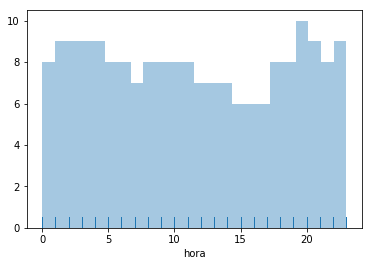

In [45]:
sns.distplot(dataset[dataset["class"]==1]["hora"], bins=24, kde=False, rug=True);

In [46]:
#target = "O3_max_frcst_"
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [47]:
hora = 11

#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(str(item+"_frcst_"+str(hours_target)),axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]
X = X.drop(["fecha"],axis=1)#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=333)

## Regresión

In [48]:
from xgboost import XGBClassifier

In [49]:
model_11 = XGBClassifier()

In [50]:
model_11.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [51]:
pronos_2_q = model_11.predict(X_test)

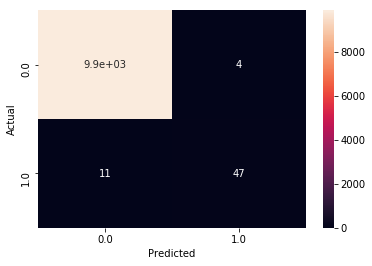

In [52]:
data = {'y_Predicted': pronos_2_q,
        'y_Actual': y_test
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

In [53]:
specifity_model_one = specifity(pronos_2_q,y_test)
specifity_model_one

3.1333333333333333

### Filtro por importancia para clasificador

In [54]:
thresholds = sort(model_11.feature_importances_)

thresholds_filter = [thresholds[-150:][i] for i in range(0,len(thresholds[-150:]),6)]#[-140:-100]

In [55]:
model_significance = XGBClassifier()

In [61]:
thresholds = sort(model_11.feature_importances_)

thresholds_filter = [thresholds[-250:][i] for i in range(0,len(thresholds[-250:]),10)]#[-140:-100]

In [62]:
Specifity_list=[]
thresh_list=[]
n_list=[]
for thresh in range(len(thresholds_filter)):
    # select features using threshold
    selection = SelectFromModel(model_11, threshold=thresholds_filter[thresh], prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = model_significance
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    specifity_score = round(specifity(y_pred,y_test),3)
    print(str(len(thresholds_filter)-thresh-1)+"  Thresh: "+ str(thresholds_filter[thresh]*10) + " n:"+str(select_X_train.shape[1])+ 
          " Specifity: "+ str(specifity_score))
    
    Specifity_list.append(specifity_score)
    thresh_list.append(thresholds_filter[thresh]*10)
    n_list.append(select_X_train.shape[1])

24  Thresh: 0.0 n:615 Specifity: 3.133
23  Thresh: 0.0 n:615 Specifity: 3.133
22  Thresh: 0.0 n:615 Specifity: 3.133
21  Thresh: 0.0 n:615 Specifity: 3.133
20  Thresh: 0.0 n:615 Specifity: 3.133
19  Thresh: 0.0 n:615 Specifity: 3.133
18  Thresh: 0.0010511773871257901 n:190 Specifity: 3.133
17  Thresh: 0.006848552729934454 n:180 Specifity: 3.133
16  Thresh: 0.010119701037183404 n:170 Specifity: 2.938
15  Thresh: 0.012794708600267768 n:160 Specifity: 2.938
14  Thresh: 0.016864517237991095 n:150 Specifity: 2.938
13  Thresh: 0.019148760475218296 n:140 Specifity: 2.938
12  Thresh: 0.022502588108181953 n:130 Specifity: 2.938
11  Thresh: 0.02476372756063938 n:120 Specifity: 2.706
10  Thresh: 0.026779307518154383 n:110 Specifity: 2.706
9  Thresh: 0.03367295255884528 n:100 Specifity: 2.5
8  Thresh: 0.03980241250246763 n:90 Specifity: 2.875
7  Thresh: 0.04553742706775665 n:80 Specifity: 2.316
6  Thresh: 0.05361140239983797 n:70 Specifity: 2.706
5  Thresh: 0.05784041713923216 n:60 Specifity: 2.44

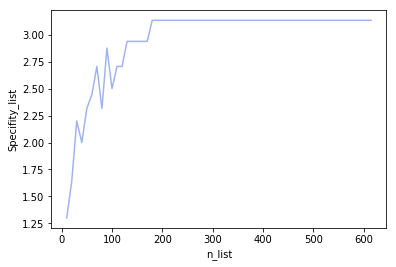

In [64]:
plt.plot(n_list, Specifity_list,alpha=0.5,color="royalblue")

plt.xlabel('n_list')
plt.ylabel('Specifity_list')
plt.show()

#### thresh = 458+25*5 = 583

In [65]:
contaminante

'PM25mean'

In [68]:
if contaminante == "O3":
    id_threshold=len(thresholds)-6*7
elif contaminante =="PM10mean":
    id_threshold=len(thresholds)-6*16
elif contaminante =="PM25mean":
    id_threshold=len(thresholds)-10*18

In [70]:
thresholds[id_threshold]

0.0006848553

In [71]:
rmse_list=[]
thresh_list=[]
n_list=[]
thresh = thresholds[id_threshold]
# select features using threshold
selection = SelectFromModel(model_11, threshold=thresh, prefit=True)

In [72]:
select_X_train = selection.transform(X_train)
# train model

In [73]:
selection_model = XGBClassifier(n_estimators=120)
selection_model.fit(select_X_train, y_train)
# eval model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=120, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [74]:
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
specifity_score = round(specifity(y_pred,y_test),2)
print("Thresh=%.5f, n=%d, Accuracy: %.2f" % (thresh, select_X_train.shape[1], specifity_score))

Thresh=0.00068, n=180, Accuracy: 3.43


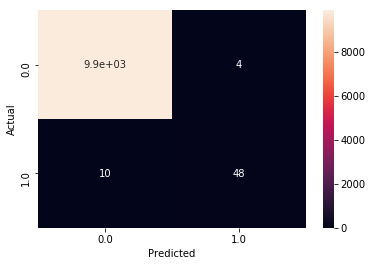

In [75]:
data = {'y_Predicted': predictions,
        'y_Actual': y_test
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [76]:
feature_idx = selection.get_support()
feature_name = X_train.columns[feature_idx]
variables_mas_correlacionadas_con_pronóstico = feature_name.tolist()

Agregamos a las columnas mas correlacionadas los atributos de pronóstico:

In [77]:
variables_mas_correlacionadas_con_pronóstico.append("RH_mean")
variables_mas_correlacionadas_con_pronóstico.append("WSP_mean")
variables_mas_correlacionadas_con_pronóstico.append("TMP_mean")
variables_mas_correlacionadas_con_pronóstico.append("fecha")
variables_mas_correlacionadas_con_pronóstico.append("O3_max")
variables_mas_correlacionadas_con_pronóstico = list(set(variables_mas_correlacionadas_con_pronóstico))

In [78]:
data_hour_merge = data_hour_merge[variables_mas_correlacionadas_con_pronóstico]

## 5. 
### Generar las columnas del contaminante a pronosticar de 1 hasta 23 horas.


Al tratarse de modelos supervisados, es necesario tener como columna cada uno de los valores a pronosticar, esta columna es la columna del contaminante recorrido desde 1 hasta 24 horas atrás:

Definimos el contaminante que estamos usando:

In [79]:
if contaminante == 'PM10' or contaminante == 'PM2.5':
    item = contaminante+"mean_max"
else:
    item = contaminante+"_max" 
print(item)

PM25mean_max


In [82]:
for i in range(1, 25):
    col_name = str(item+"_frcst_"+str(i))
    data_hour_merge[col_name] = data_hour_merge[item].shift(i)
    if i==range(1, 25)[-1]:
        print(i)
data_hour_merge.dropna(inplace=True)

24


Guardemos:

In [81]:
data_hour_merge.to_csv("./datos/datos_modelos_"+ contaminante + ".csv",sep=',', encoding='utf-8',index=False)

In [76]:
"./datos/datos_modelos_"+ contaminante + ".csv"

'./datos/datos_modelos_PM10mean.csv'

In [291]:
data_hour_merge.columns.tolist()

['PM10mean_30.0_max',
 'NO2_21.0_min',
 'PM10_1.0_max',
 'RH_mean_frcst_21',
 'NO2_16.0_mean',
 'PM10_2.0_max',
 'NO2_3.0_mean',
 'NO2_23.0_mean',
 'PM10_1.0_mean',
 'PM2.5_27.0_mean',
 'PM10mean_11.0_max',
 'PM10mean_31.0_max',
 'CO_min',
 'PM2.5_14.0_max',
 'PM10_4.0_max',
 'PM2.5_1.0_max',
 'TMP_mean_frcst_18',
 'TMP_mean_frcst_4',
 'hora',
 'PM10mean_23.0_mean',
 'PM2.5_8.0_max',
 'RH_min',
 'PM2.5_29.0_max',
 'PM10mean_28.0_min',
 'WSP_mean_frcst_7',
 'PM2.5_3.0_max',
 'PM10mean_31.0_min',
 'TMP_mean_frcst_24',
 'PM10_6.0_mean',
 'RH_mean_frcst_3',
 'WSP_mean',
 'PM2.5_23.0_mean',
 'RH_mean_frcst_23',
 'PM2.5_5.0_max',
 'PM2.5_4.0_mean',
 'PM10_7.0_mean',
 'PM10_max',
 'PM25mean_17.0_mean',
 'PM25mean_12.0_mean',
 'RH_mean_frcst_4',
 'PM10mean_33.0_max',
 'PM10mean_32.0_max',
 'PM10_4.0_mean',
 'PM10mean_30.0_mean',
 'PM10_23.0_mean',
 'PM10mean_20.0_min',
 'RH_mean',
 'PM10mean_20.0_max',
 'RH_mean_frcst_22',
 'PM10mean_29.0_mean',
 'PM25mean_30.0_min',
 'PM25mean_36.0_mean',
 'P

KeyError: "None of [Index(['O3_max_frcst_4'], dtype='object')] are in the [columns]"

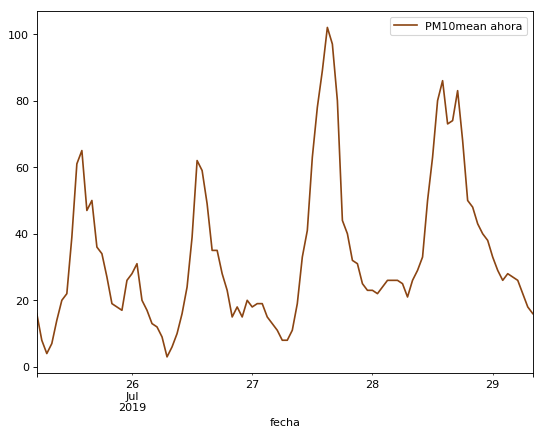

In [292]:
data_hour_merge['fecha'] =  pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M')

import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])

data_hour_merge.head(100).plot(x="fecha", y=["O3_max"],ax=ax,label=["PM10mean ahora"],color="saddlebrown")
data_hour_merge.head(100).plot(x="fecha", y=["O3_max_frcst_4"],ax=ax,label=["PM10 pronostico 12"],color="blue")
data_hour_merge.head(100).plot(x="fecha", y=["O3_4.0_max"],ax=ax,label=["PM10 a pasado"],color='maroon',dashes=[6, 2])


plt.ylabel("PM10[mg/m3]")
plt.title("Comparación del Modelo")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)



plt.legend()
plt.show()